In [ ]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


In [ ]:
import os
import pickle

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
from torch import nn
from torch.optim import Adam

from transformers import BertTokenizer, BertModel

from tqdm import tqdm

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
np.random.seed(42)

EPOCHS = 20
BATCH_SIZE = 16
LR = 1e-6

## Load Data

In [ ]:
paths = pickle.load(open('data/science/paths.pkl', 'rb'))

In [ ]:
def ff(path_str):
    id = path_str[:-1]
    if path_str[-1] == 'r':
        return paths[id]['reverse']
    else:
        return paths[id]['forward']
def fff(ans):
    paths_str = ans.split('_')
    return {
        'A': ff(paths_str[0]),
        'B': ff(paths_str[1]),
        'better': 'A' if paths_str[2] == paths_str[0] else 'B'
    }
    return list(map(ff, paths_str))
with open('data/science/answers.txt', 'r') as f:
    answers = list(map(fff, filter(lambda x: len(x) > 0, f.read().split('\n'))))

In [ ]:
answers[0]['A']

{'text': 'Piece is a type of Part. Part is related to Car. you are likely to find Car in/at/on Land. ',
 'short': 'Piece --IsA--> Part <--RelatedTo--> Car --AtLocation--> Land '}

In [ ]:
answers[0]['B']

{'text': 'Dream is related to Day. Day is related to Measurement. Measurement is related to Year. ',
 'short': 'Dream <--RelatedTo--> Day <--RelatedTo--> Measurement <--RelatedTo--> Year '}

In [ ]:
answers[0]['better']

'A'

In [ ]:
text_arr = []
label_arr = []

for ans in answers:
#     text_arr.append(ans['A']['text'])
#     text_arr.append(ans['B']['text'])
#     if ans['better'] == 'A':
#         label_arr.append(1)
#         label_arr.append(0)
#     else:
#         label_arr.append(0)
#         label_arr.append(1)
    text_arr.append(ans['A']['text'] + ans['B']['text'])
    text_arr.append(ans['B']['text'] + ans['A']['text'])
    if ans['better'] == 'A':
        label_arr.append(1)
        label_arr.append(0)
    else:
        label_arr.append(0)
        label_arr.append(1)

In [ ]:
data_df = pd.DataFrame(data={
    'Text': text_arr,
    'Label': label_arr,
})

In [ ]:
train_df, val_df, test_df = np.split(data_df.sample(frac=1, random_state=42), [int(.8*len(data_df)), int(.9*len(data_df))])

print(len(train_df),len(val_df), len(test_df))

22080 2760 2760


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, text_col='Text', label_col='Label'):
        self.labels = [float(x) for x in df[label_col]]
        self.texts = [
            tokenizer(
                text, 
                padding='max_length',
                max_length = 512,
                truncation=True,
                return_tensors='pt'
            ) for text in df[text_col]
        ]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Model

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        # for param in self.bert.parameters():
        #     param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.activation = nn.Sigmoid()
    def forward(self, input_id, mask):
        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.activation(x)
        return x

## Training

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            model.train()
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device).unsqueeze(1)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                batch_loss = criterion(output.double(), train_label)
                total_loss_train += batch_loss.item()
                acc = (output.round() == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device).unsqueeze(1)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    batch_loss = criterion(output.double(), val_label)
                    total_loss_val += batch_loss.item()
                    acc = (output.round() == val_label).sum().item()
                    total_acc_val += acc
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            torch.save(model.state_dict(), 'bert_clf.pt')

In [ ]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
    y_pred_list = []
    y_test = []
    # global output_rnd
    # global test_lbl
    model.eval()
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device).unsqueeze(1)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            # output_rnd = output.round()
            # test_lbl = test_label
            # return
            y_pred_list.append(output.round().cpu().numpy())
            y_test.append(test_label.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_pred_list = [item for sublist in y_pred_list for item in sublist]
    y_test = [a.squeeze().tolist() for a in y_test]
    y_test = [item for sublist in y_test for item in sublist]
    cm = confusion_matrix(y_test, y_pred_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(classification_report(y_test, y_pred_list))

## ...

In [ ]:
model = BertClassifier()
print(model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddin

In [ ]:
model.load_state_dict(torch.load('bert_clf_e20.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# train(model, train_df, val_df, LR, EPOCHS)

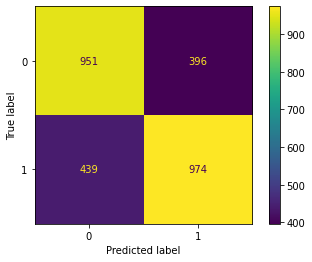

              precision    recall  f1-score   support

         0.0       0.68      0.71      0.69      1347
         1.0       0.71      0.69      0.70      1413

    accuracy                           0.70      2760
   macro avg       0.70      0.70      0.70      2760
weighted avg       0.70      0.70      0.70      2760



In [ ]:
y = evaluate(model, test_df)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ae8bd3f4-1eb1-4931-aeae-03a910b193bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>